In [5]:
from google.colab import drive
drive.mount('/content/drive')


import os
from shutil import copy2
import csv
import tensorflow as tf



from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt


!pip install tensorflow_hub


import tensorflow_hub as hub


tf.__version__


import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [6]:

# Set the data root directory
data_root = "/content/drive/My Drive/FYP/Dataset/train"

# Image size for resizing
IMAGE_SHAPE = (224, 224)

# Create ImageDataGenerators with validation split
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

# Define training and validation generators
train_generator = train_datagen.flow_from_directory(
    data_root,  # Directory for training data
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=32
)

valid_generator = valid_datagen.flow_from_directory(
    data_root,  # Directory for validation data
    subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=32
)

# Print the class indices to verify
print("Class Indices (Training):", train_generator.class_indices)
print("Class Indices (Validation):", valid_generator.class_indices)

# Save labels to a text file
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

# Print the labels
!cat labels.txt



Found 743 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Class Indices (Training): {'Glaucous_Winged_Gull': 0, 'Slaty_Backed_Gull': 1}
Class Indices (Validation): {'Glaucous_Winged_Gull': 0, 'Slaty_Backed_Gull': 1}
Glaucous_Winged_Gull
Slaty_Backed_Gull

In [7]:
import tensorflow as tf

# Define the input shape
input_shape = (224, 224, 3)

# Load the MobileNetV2 model pre-trained on ImageNet, excluding the top layers
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # Load pre-trained weights
    include_top=False,   # Exclude the top (fully-connected) layers
    input_shape=input_shape
)

# Freeze the base model layers
base_model.trainable = False

# Define the model using the Functional API
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Display model summary
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:


     # Define the number of epochs
epochs = 40

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,  # Use valid_generator if you have validation data
    epochs=epochs,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size if valid_generator else None,
    verbose=1
)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.6038 - loss: 0.7179 - val_accuracy: 0.7625 - val_loss: 0.4511
Epoch 2/40
 1/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6875 - loss: 0.5914

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.6875 - loss: 0.5914 - val_accuracy: 0.5000 - val_loss: 0.6686
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8070 - loss: 0.4475 - val_accuracy: 0.8438 - val_loss: 0.3346
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7500 - loss: 0.4333 - val_accuracy: 0.8333 - val_loss: 0.3359
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8080 - loss: 0.4156 - val_accuracy: 0.8875 - val_loss: 0.2613
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8125 - loss: 0.3745 - val_accuracy: 0.8750 - val_loss: 0.2788
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8659 - loss: 0.3392 - val_accuracy: 0.9125 - val_loss: 0.2370
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8750 - loss: 0.3522 - val_accuracy: 0.8750 - val_loss: 0.2929
Epoch 9/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8575 - loss: 0.3305 - val_accuracy: 0.9438 - val_loss: 0.214

Save trained model check performance

In [9]:
test_loss, test_acc = model.evaluate(valid_generator, verbose=2)
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")

6/6 - 10s - 2s/step - accuracy: 0.9511 - loss: 0.1601
Validation Loss: 0.16009946167469025
Validation Accuracy: 0.9510869383811951


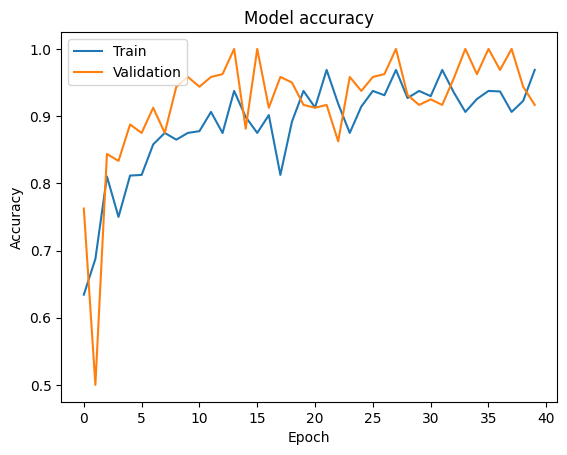

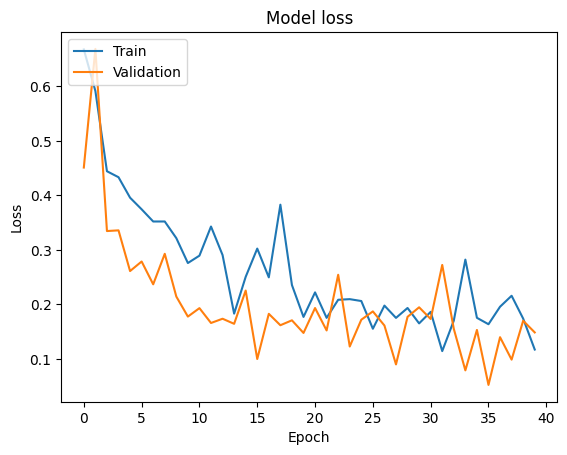

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [16]:
# Save the model

model.save('my_model.h5')
model.save('/content/drive/My Drive/FYP/MODELS/trained_model.h5')

from google.colab import files
files.download('my_model.h5')

# Load the model (when needed)
loaded_model = tf.keras.models.load_model('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img_path = '/content/1200 - 2024-08-18T191835.473.jpeg'
img = image.load_img(img_path, target_size=input_shape[:2])
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Scale the image

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class
print(f"Predicted class: {list(train_generator.class_indices.keys())[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Slaty_Backed_Gull
